# Setup:

In [74]:
#Load libraries
import os
import pandas as pd
import numpy as np
from fancyimpute import KNN   
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
#Set working directory
os.chdir("/home/gid/Documents/project_1")

# Functions:

In [76]:

#Function to segregate the different data types present in the dataframe.
def dtype_separator(df, col_names):
    '''
    #################################################################################################
    This function will segregate the different data types present in the dataframe.
    #################################################################################################
    Input -
    * df - The data frame to be analysed.
    *A list of the column names.
    Output - 
    * obj - columns containing object data type.
    * num - columns containing numerical data type (int64/float64).
    * bool_d - columns containing bool data type.
    * unknown = columns containing data type such as datetime64, timedelta[ns] and others.
    ################################################################################################
    '''
    obj = []
    num = []
    bool_d = []
    unknown = []
    for i in range(len(col_names)):
        if df.iloc[:,i].dtype == 'O':
            obj.append(col_names[i])
        elif df.iloc[:,i].dtype == 'int64' or df.iloc[:,i].dtype == 'float64':
            num.append(col_names[i])
        elif df.iloc[:,i].dtype == 'bool':
            bool_d.append(col_names[i])
        else:
            unknown.append(col_names[i])
    return obj, num, bool_d, unknown

In [77]:
#Function to view the categories present in each categorical feature
def view_feature_cat(obj):
    '''
    ###################################################################################################
    This function will display the categories present in each categorical variable (i.e. Feature). 
    ###################################################################################################
    Input -
    *obj - A list of the caegorical column names (i.e. caegorical features).
    Output - 
    *Displays on the screen, the different categorical features and the catogeries present in them. 
    It also displays the count of each category in the feature. 
    
    This helps us have an easy over view of the categories present in the features and infer on there
    significance
    ###################################################################################################
    '''
    for i in range(len(obj)):
        print('*******************************************')
        print('Feature:',obj[i])
        print('-----------------------')
        print(df[str(obj[i])].value_counts())
        print('*******************************************')

In [78]:
def outlier_percent(df):
    '''
    ###################################################################################################
    This function will print out the total number of outliers present in data and percentage of 
    outliers present in data set.
    ###################################################################################################
    Input -
    * df - The dataframe is take as input.
    Output - 
    * print out the total number of outliers and percentage of outliers present in data set
    ###################################################################################################
    '''
    l_q = df.quantile(0.25)
    u_q = df.quantile(0.75)
    iqr = u_q - l_q
    total_outliers = ((df<(l_q - 1.5*iqr))|(df>(u_q + 1.5*iqr))).sum()
    outliers = total_outliers.sum()
    print('Total number of outliers present =',outliers)
    r,c = df.shape
    outlier_percentage = (outliers/r)*100
    print("Outlier percentage :",round(outlier_percentage,3))

In [79]:

#Function to perform outlier analysis
def outlier_analysis(df, cnames, method):
    '''
    ###################################################################################################
    This function will perform outlier analysis on the given data. This function deals with outliers in 
    two ways, which are as follows:
    - Delete outliers from data.
    - Detect and replace with NA and then perform KNN KNN Imputation for missing value on it.
    ###################################################################################################
    Input -
    * df - The dataframe is take as input.
    * cnames - List of column names.
    * method - There are two options (0 or 1), which performs the following operation:
        - Detect and delete outliers from data.
        - Detect and replace with NA and then perform KNN KNN Imputation for missing value on it.
    Output - 
    * df - It returns a dataframe after performing outlier analysis.
    ###################################################################################################
    '''
    if method == 0:
        #Detect and delete outliers from data
        for i in cnames:
            q75, q25 = np.percentile(df.loc[:,i], [75 ,25])
            iqr = q75 - q25

            low_qutr = q25 - (iqr*1.5)
            up_qutr = q75 + (iqr*1.5)
    
            df = df.drop(df[df.loc[:,i] < low_qutr].index)
            df = df.drop(df[df.loc[:,i] > up_qutr].index)
        return df
    elif method == 1:
        for i in cnames:
            #Detect and replace with NA
            # #Extract quartiles
            q75, q25 = np.percentile(df[i], [75 ,25])

            #Calculate IQR
            iqr = q75 - q25

            #Calculate inner and outer fence
            low_qutr = q25 - (iqr*1.5)
            up_qutr = q75 + (iqr*1.5)

            #Replace with NA
            df.loc[df[i] < low_qutr,:i] = np.nan
            df.loc[df[i] > up_qutr,:i] = np.nan
            #Impute with KNN
            df = pd.DataFrame(KNN(k = 3).fit_transform(df[i]), columns = df.columns)
        return df
    else:
        print('Error: incorrect input')

In [80]:
def drop_list(columns, rows, treshold):
    '''
    ###################################################################################################
    This function will select the features whose corelation excides the treshold
    ###################################################################################################
    Input -
    * columns - Corelation matrix column index.
    * row - Row matrix column index.
    * treshold - * columns - Corelation treshold.
    Output - 
    * drop - List of features to be dropped
    ###################################################################################################
    '''

    drop = []
    drop_val = []
    for i in list(range(0,len(columns))):
        for j in list(range(0, len(rows))):
            if columns[i] != rows[j]:
                if abs(corr.loc[rows[j],columns[i]]) >= abs(treshold):
                    drop.append(rows[j]) if rows[j] and columns[i] not in drop else print('repeat')
                    drop_val.append(corr.loc[rows[j],columns[i]])
    return drop

In [81]:

def drop_features(drop_feat, obj_dtype, num_dtype):
    '''
    ###################################################################################################
    This function will remove the dropped features from the variables containing the object feature 
    names and numeric feature names, obj_dtype and num_dtype respectively.
    ###################################################################################################
    Input -
    * drop_feat - List containing the names of the dropped fratures.
    * obj_dtypes - List of all the categorical feature names.
    * num_dtypes - List of all the numeric feature names.
    Output - 
    * obj_d - List containing the categorical feature names excluding the dropped features.
    * num_d - List containing the numeric feature names excluding the dropped features.
    ###################################################################################################
    '''
    obj_del = []
    num_del = []
    for i in range(0, len(drop_feat)):
        #print(i)
        if(drop_feat[i] in obj_dtype):
            #print('obj in',i)
            ## Dropping deleted object variable name from obj_dtype variable
            obj_del.append(drop_feat[i])
        
        elif(drop_feat[i] in num_dtype):
            #print('num in',i)
            ## Dropping deleted numeric variable name from num_dtype variable
            num_del.append(drop_feat[i])
        
        else:
            print('Data type', i ,'is not an object or numeric.')
    obj_d= list(set(obj_dtype).difference(set(obj_del)))
    num_d= list(set(num_dtype).difference(set(num_del)))
    return obj_d, num_d

In [82]:
#Function to compute MAPE
def MAPE(y_true, y_pred):
    '''
    ###################################################################################################
    This function will Mean Absolute Percent Error (MAPE).
    ###################################################################################################
    Input -
    * y_true - Actual values from y_test.
    * y_pred - Predicted values.
    Output - 
    * mape - Mean Absolute Percent Error as error percentage.
    ###################################################################################################
    '''
    mape = np.mean(np.abs((y_true - y_pred) / y_true))*100
    return mape

# Exploratory Data Analysis:

In [83]:
#Load data
df = pd.read_csv("day.csv")

In [84]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


From viewing the data set, it can seen that the feature instance is just the index of the records. Causal and registered are the count of the respective type of users which is not required as we have the total count. Hence instance, causal and registered features are dropped from the data set. The dteday is the date of the records which is not required as we are not conducting a time series analysis. Hence even dteday feature is also dropped from the data set.

In [85]:
df = df.drop(['instant','dteday','casual','registered'],axis=1)

In [86]:
df.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,8714.000000


In [87]:
#Calling function 'dtype_separator' to segregate different data types
obj_dtype, num_dtype, bool_dtype, unknown_dtype = dtype_separator(df, df.columns)

In [88]:
df.dtypes

season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

In [89]:
## Note:- while seperating data types it was noticed that several of the categorical variable are stored as int.
## Hence these variables are to be converted to object data type.

## Create a list of variables which are incorrectly classified as numeric
convert_obj = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

In [90]:
for i in convert_obj:
    df.loc[:,i] = df.loc[:,i].astype("object")

df.dtypes

season         object
yr             object
mnth           object
holiday        object
weekday        object
workingday     object
weathersit     object
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

In [91]:
#Calling function 'dtype_separator' to segregate different data types
obj_dtype, num_dtype, bool_dtype, unknown_dtype = dtype_separator(df, df.columns)


## Distribution Plots:

### Distribution Analysis Of Continous Variables

/home/gid/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


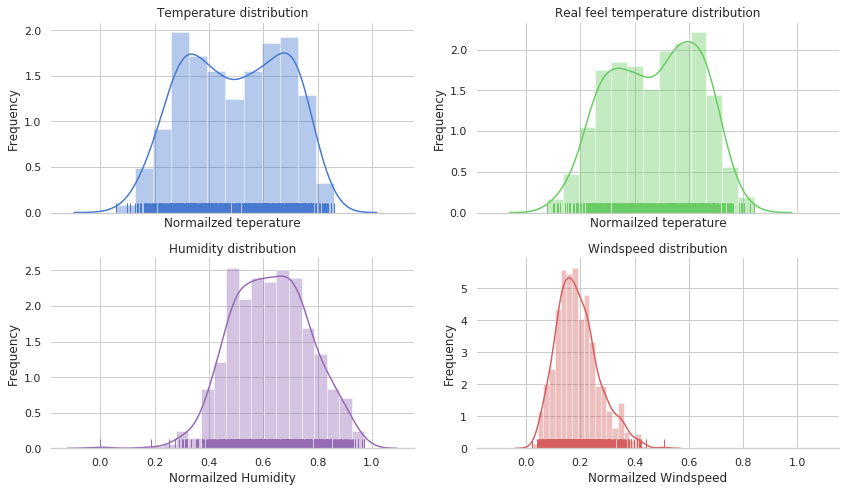

In [92]:
# Set up the matplotlib figure
sns.set(style="whitegrid", palette="muted", color_codes=True)
f, axes = plt.subplots(2, 2, figsize=(12, 7), sharex=True)
sns.despine(left=True)

# Plot a historgram and kernel density estimate
ax1 = sns.distplot(df['temp'], rug=True, color="b", ax=axes[0, 0])
ax1.set_title('Temperature distribution')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Normailzed teperature')
# Plot a historgram and kernel density estimate
ax2 = sns.distplot(df['atemp'], rug=True, color="g", ax=axes[0, 1])
ax2.set_title('Real feel temperature distribution')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Normailzed teperature')
# Plot a historgram and kernel density estimate
ax3 = sns.distplot(df['hum'], rug=True, color="m", ax=axes[1, 0])
ax3.set_title('Humidity distribution')
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Normailzed Humidity')
# Plot a historgram and kernel density estimate
ax4 = sns.distplot(df['windspeed'], rug=True, color="r", ax=axes[1, 1])
ax4.set_title('Windspeed distribution')
ax4.set_ylabel('Frequency')
ax4.set_xlabel('Normailzed Windspeed')
plt.tight_layout()
plt.savefig('distribution_plot.pdf')

Check the skewness of the continous variables

In [93]:
print("*******************************************************************")
for i in num_dtype:
    from scipy import stats
    skewness = stats.describe(df.loc[:,i])
    print("statistical properities of {0:5s}:".format(i))
    print(skewness)
    print("*******************************************************************")

*******************************************************************
statistical properities of temp :
DescribeResult(nobs=731, minmax=(0.0591304, 0.861667), mean=0.495384788508892, variance=0.03350766717740828, skewness=-0.05440902480571618, kurtosis=-1.1194225488473057)
*******************************************************************
statistical properities of atemp:
DescribeResult(nobs=731, minmax=(0.0790696, 0.8408959999999999), mean=0.47435398864569084, variance=0.026556345661055174, skewness=-0.1308188980737412, kurtosis=-0.9866019052943136)
*******************************************************************
statistical properities of hum  :
DescribeResult(nobs=731, minmax=(0.0, 0.9725), mean=0.6278940629274967, variance=0.02028604714193028, skewness=-0.06964015783152368, kurtosis=-0.07228631791987006)
*******************************************************************
statistical properities of windspeed:
DescribeResult(nobs=731, minmax=(0.0223917, 0.507463), mean=0.1904862116

It can said that the continuous variables are all mostly normally distributed but there is a slight skew in all of them. This could be due to some outliers present in the data set.

### Distibution Analysis Of Categorical Features

In [94]:
view_feature_cat(obj_dtype)

*******************************************
Feature: season
-----------------------
3    188
2    184
1    181
4    178
Name: season, dtype: int64
*******************************************
*******************************************
Feature: yr
-----------------------
1    366
0    365
Name: yr, dtype: int64
*******************************************
*******************************************
Feature: mnth
-----------------------
12    62
10    62
8     62
7     62
5     62
3     62
1     62
11    60
9     60
6     60
4     60
2     57
Name: mnth, dtype: int64
*******************************************
*******************************************
Feature: holiday
-----------------------
0    710
1     21
Name: holiday, dtype: int64
*******************************************
*******************************************
Feature: weekday
-----------------------
6    105
1    105
0    105
5    104
4    104
3    104
2    104
Name: weekday, dtype: int64
**********************************

The unique values and their size is printed above

## Missing Values Analysis

In [95]:
## Missing values analysis
pd.DataFrame(df.isnull().sum())


,0
season,0
yr,0
mnth,0
holiday,0
weekday,0
workingday,0
weathersit,0
temp,0
atemp,0
hum,0


It is found that there is no missing values in the data set

## Outlier Analysis

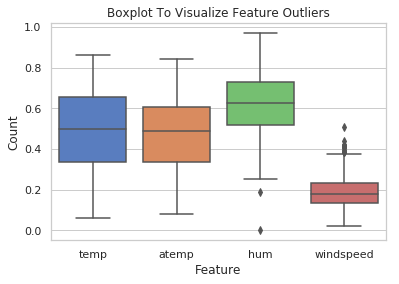

In [96]:
###############################################################################################################
## Outlier analysis
################################################################################################################

# #Plot boxplot to visualize Feature variable Outliers
ax_o1 = sns.boxplot(data= df.iloc[:,7:11])
ax_o1.set_title('Boxplot To Visualize Feature Outliers')
ax_o1.set_ylabel('Count')
ax_o1.set_xlabel('Feature')
plt.savefig('feature_outlier1.pdf')

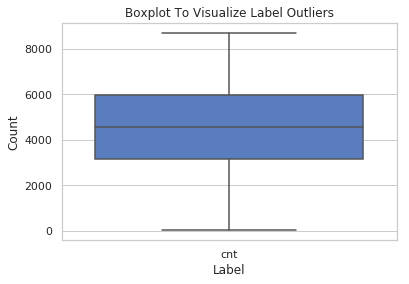

In [97]:
# #Plot boxplot to visualize Target variable Outliers
ax_o2 = sns.boxplot(data= df.iloc[:,11:12])
ax_o2.set_title('Boxplot To Visualize Label Outliers')
ax_o2.set_ylabel('Count')
ax_o2.set_xlabel('Label')
plt.savefig('label_outlier1.pdf')

In [98]:
#Calling the outlier function to compute and print outlier percent
outlier_percent(df)

Total number of outliers present = 15
Outlier percentage : 2.052


In [99]:
#Calling the outlier function to perform outlier analysis
method = 0
df = outlier_analysis(df, num_dtype, method)
df.describe()

,temp,atemp,hum,windspeed,cnt
count,717.000000,717.000000,717.000000,717.000000,717.000000
mean,0.497365,0.476252,0.631562,0.186287,4532.843794
std,0.183617,0.163155,0.139222,0.071786,1933.542429
min,0.059130,0.079070,0.254167,0.022392,22.000000
25%,0.337500,0.337939,0.524583,0.134329,3214.000000
50%,0.505833,0.491783,0.630833,0.178496,4570.000000
75%,0.656667,0.611121,0.732917,0.230721,6031.000000
max,0.861667,0.840896,0.972500,0.378108,8714.000000


As we removed the records containing outliers. The number of records in our data set will reduce which would lead to a change in the mean. Due to this we may find new values which would be outliers in our data set. We could perform outlier analysis till we bring the percentage of outliers in our dataset to a negligible value.


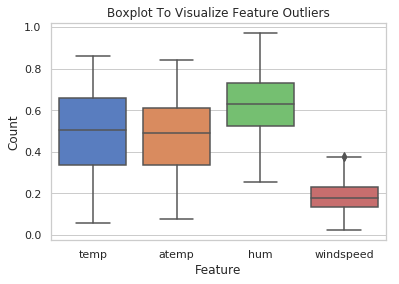

In [100]:
# #Plot boxplot to visualize Feature variable Outliers
ax_o1 = sns.boxplot(data= df.iloc[:,7:11])
ax_o1.set_title('Boxplot To Visualize Feature Outliers')
ax_o1.set_ylabel('Count')
ax_o1.set_xlabel('Feature')
plt.savefig('feature_outlier2.pdf')

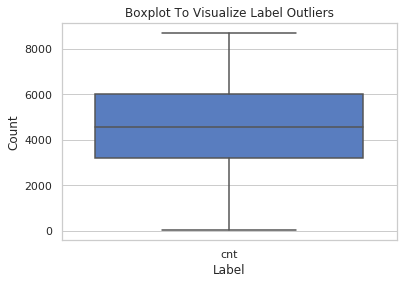

In [101]:
# #Plot boxplot to visualize Target variable Outliers
ax_o2 = sns.boxplot(data= df.iloc[:,11:12])
ax_o2.set_title('Boxplot To Visualize Label Outliers')
ax_o2.set_ylabel('Count')
ax_o2.set_xlabel('Label')
plt.savefig('label_outlier2.pdf')

In [102]:
#Calling the outlier function to compute and print outlier percent
outlier_percent(df)

Total number of outliers present = 3
Outlier percentage : 0.418


In [103]:
#Calling the outlier function to perform outlier analysis
method = 0
df = outlier_analysis(df, num_dtype, method)
df.describe()

,temp,atemp,hum,windspeed,cnt
count,714.000000,714.000000,714.000000,714.000000,714.000000
mean,0.497728,0.476665,0.631748,0.185486,4542.637255
std,0.183502,0.162945,0.138937,0.070862,1930.870310
min,0.059130,0.079070,0.254167,0.022392,22.000000
25%,0.340000,0.338362,0.525580,0.133873,3230.750000
50%,0.505833,0.492104,0.630833,0.178481,4575.500000
75%,0.656667,0.611120,0.732813,0.229939,6033.250000
max,0.861667,0.840896,0.972500,0.374383,8714.000000


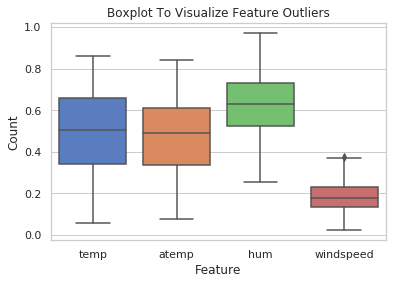

In [104]:
# #Plot boxplot to visualize Feature variable Outliers
ax_o1 = sns.boxplot(data= df.iloc[:,7:11])
ax_o1.set_title('Boxplot To Visualize Feature Outliers')
ax_o1.set_ylabel('Count')
ax_o1.set_xlabel('Feature')
plt.savefig('feature_outlier3.pdf')

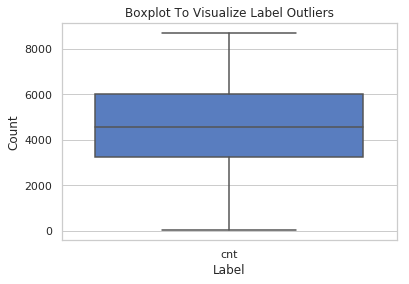

In [105]:
# #Plot boxplot to visualize Target variable Outliers
ax_o2 = sns.boxplot(data= df.iloc[:,11:12])
ax_o2.set_title('Boxplot To Visualize Label Outliers')
ax_o2.set_ylabel('Count')
ax_o2.set_xlabel('Label')
plt.savefig('label_outlier3.pdf')

In [106]:
#Calling the outlier function to compute and print outlier percent
outlier_percent(df)

Total number of outliers present = 1
Outlier percentage : 0.14


In [107]:
#Calling the outlier function to perform outlier analysis
method = 0
df = outlier_analysis(df, num_dtype, method)
df.describe()

,temp,atemp,hum,windspeed,cnt
count,713.000000,713.000000,713.000000,713.000000,713.000000
mean,0.497968,0.476911,0.631853,0.185221,4543.927069
std,0.183518,0.162927,0.139006,0.070557,1931.917955
min,0.059130,0.079070,0.254167,0.022392,22.000000
25%,0.340000,0.338363,0.525217,0.133721,3228.000000
50%,0.505833,0.492425,0.630833,0.178479,4576.000000
75%,0.656667,0.611121,0.732917,0.229479,6034.000000
max,0.861667,0.840896,0.972500,0.368167,8714.000000


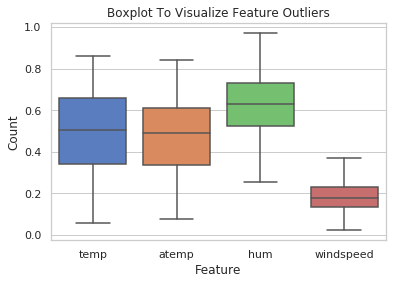

In [108]:
# #Plot boxplot to visualize Feature variable Outliers
ax_o1 = sns.boxplot(data= df.iloc[:,7:11])
ax_o1.set_title('Boxplot To Visualize Feature Outliers')
ax_o1.set_ylabel('Count')
ax_o1.set_xlabel('Feature')
plt.savefig('feature_outlier4.pdf')

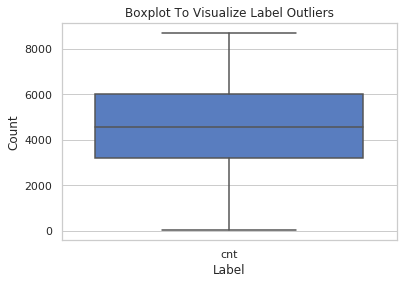

In [109]:
# #Plot boxplot to visualize Target variable Outliers
ax_o2 = sns.boxplot(data= df.iloc[:,11:12])
ax_o2.set_title('Boxplot To Visualize Label Outliers')
ax_o2.set_ylabel('Count')
ax_o2.set_xlabel('Label')
plt.savefig('label_outlier4.pdf')

In [110]:
#Calling the outlier function to compute and print outlier percent
outlier_percent(df)

Total number of outliers present = 0
Outlier percentage : 0.0


## Data Understanding

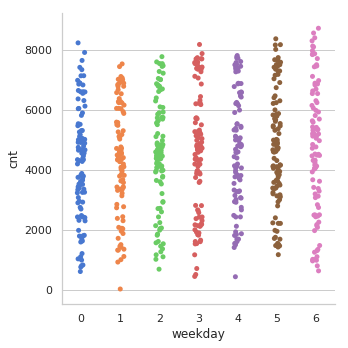

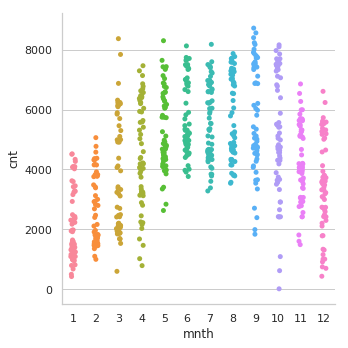

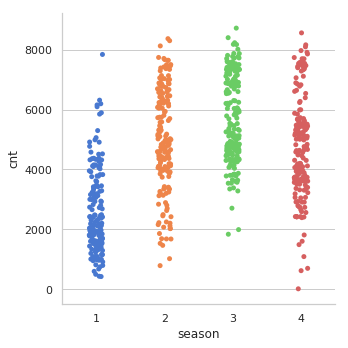

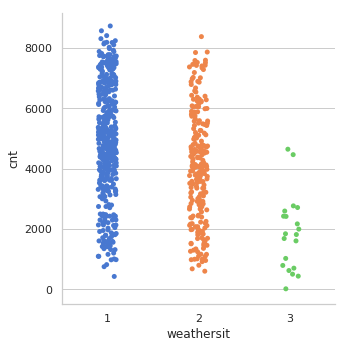

In [111]:
sns.catplot(x="weekday", y="cnt", data=df)
plt.savefig('days_bikecnt_plot.pdf')

sns.catplot(x="mnth", y="cnt", data=df)
plt.savefig('mnth_bikecnt_plot.pdf')

sns.catplot(x="season", y="cnt", data=df)
plt.savefig('season_bikecnt_plot.pdf')

sns.catplot(x="weathersit", y="cnt", data=df)
plt.savefig('hol_bikecnt_plot.pdf')

*From the first figure above it can be said that the majority of the bike rental each day is between 3500 - 6000.
Whereas days 0, 5 and 6 is almost evenly distributed along the cnt (’bike count’) axis.

*The second igure shows that the maximum amount of rentals happen in the months 4 - 10. These months could reach rental
counts of 4000 to 8000 and even more.

*The second figure shows the variation in bike rentals based on the season. It can be observed that season 3 which is fall is the most busiest, having majority of the daily bike count between 4000 - 8000 rentals. On the other hand season 1 which is spring is the least where the majority of the daily bike count is mostly in the range 500 - 4000.

*In the last figure it can be seen that weather site forecast 3 has barley any bike rentals. This weather corresponds to Light Snow, Light Rain, Thunderstorm or or Scattered clouds.

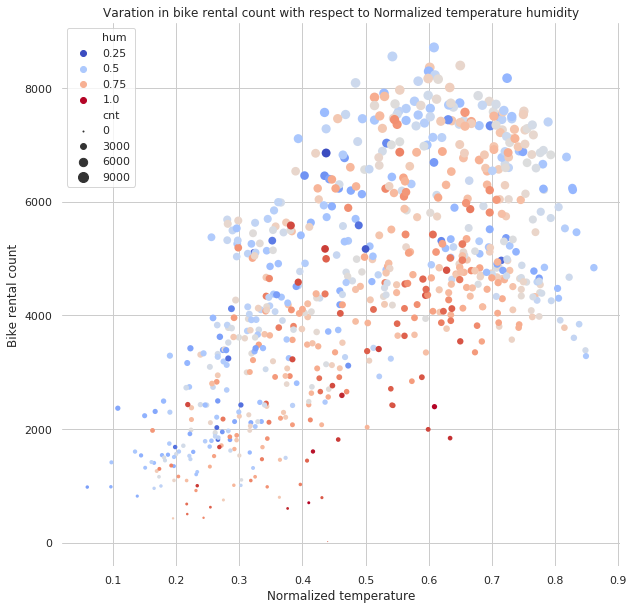

In [112]:
# variables in the dataset
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)
#clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
ax5 = sns.scatterplot(x="temp", y="cnt",
                hue="hum", size="cnt",
                palette="coolwarm",
                #hue_order=clarity_ranking,
                sizes=(1, 100), linewidth=0,
                data=df, ax=ax)
ax5.set_title("Varation in bike rental count with respect to Normalized temperature humidity")
ax5.set_ylabel("Bike rental count")
ax5.set_xlabel("Normalized temperature")
plt.savefig('bike_temph_plot.pdf')

From the above figure we can see that bike rental count is highest when humidity is below 0.75 and temperature is berween 0.4 - 0.5 normalized temperature.

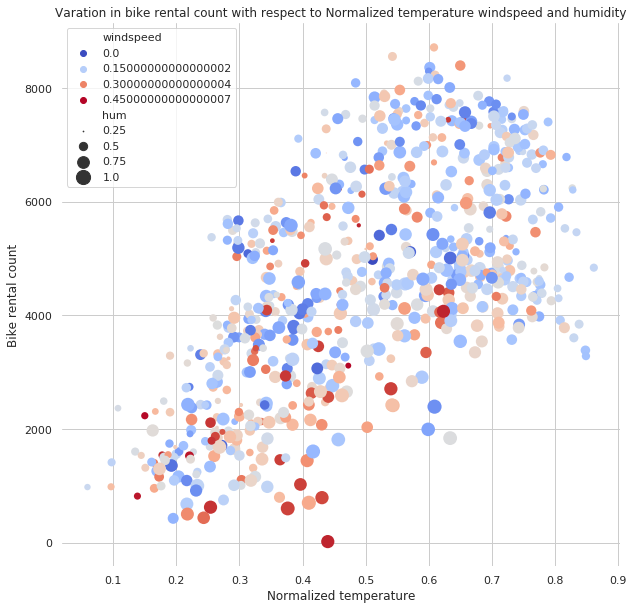

In [113]:
# variables in the dataset
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)
#clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
ax5 = sns.scatterplot(x="temp", y="cnt",
                hue="windspeed", size="hum",
                palette="coolwarm",
                #hue_order=clarity_ranking,
                sizes=(0.5, 200), linewidth=0,
                data=df, ax=ax)
ax5.set_title("Varation in bike rental count with respect to Normalized temperature windspeed and humidity")
ax5.set_ylabel("Bike rental count")
ax5.set_xlabel("Normalized temperature")
plt.savefig('bike_temphw_plot.pdf')

it could be inferred from the above figure that the optimal conditions for maximum bike count is when the normalized temperature is between 0.4 - 0.8, normalized humidity is below 0.75 and normalized winspeed is below 0.15.

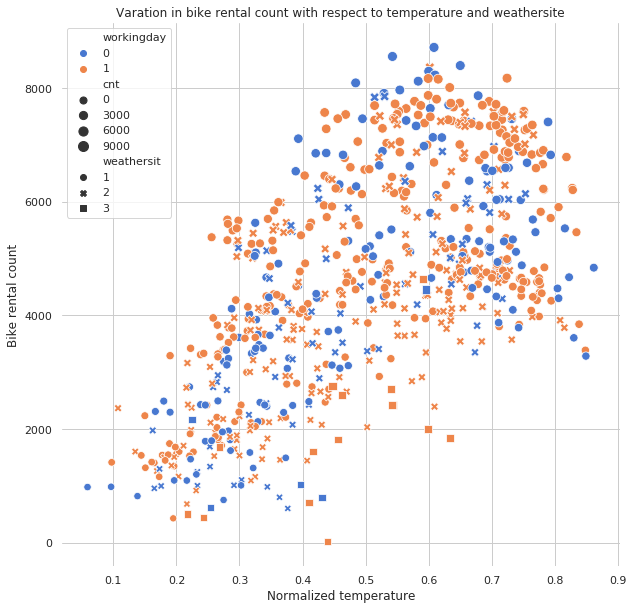

In [114]:
# variables in the dataset
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)
#clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
ax7 = sns.scatterplot(x="temp", y="cnt", hue = "workingday", style = "weathersit", size = "cnt",sizes=(50, 100),data=df)
ax7.set_title("Varation in bike rental count with respect to temperature and weathersite")
ax7.set_ylabel("Bike rental count")
ax.set_xlabel("Normalized temperature")
plt.savefig('bike_weather_plot.pdf')

It can be noted from the figure above that people rent bike mostly on working weekdays. The highest bike rentak count is achived mostly when the wheather site forcast is Clear, Few clouds, Partly cloudy, Partly cloudy and temperature between 0.5 to 0.8 normalized temperatue.

# Feature Selection:

## Correlation Analysis

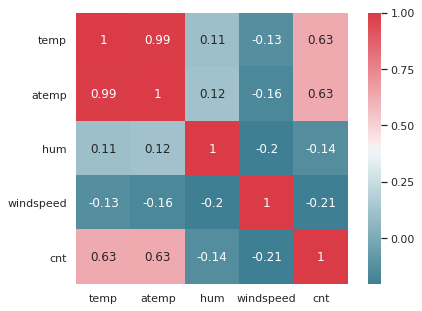

In [115]:
####################################################################################
## Correlation plot
#Correlation plot
df_corr = df.loc[:,num_dtype]
#Set the width and hieght of the plot
f, ax = plt.subplots(figsize=(7, 5))
#Generate correlation matrix
corr = df_corr.corr()
#Plot using seaborn library
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, annot=True,ax=ax)
plt.savefig('corr_plot.pdf')

In [116]:
print(corr)

               temp     atemp       hum  windspeed       cnt
temp       1.000000  0.991740  0.107904  -0.134535  0.628990
atemp      0.991740  1.000000  0.119750  -0.159116  0.632230
hum        0.107904  0.119750  1.000000  -0.203823 -0.137715
windspeed -0.134535 -0.159116 -0.203823   1.000000 -0.205826
cnt        0.628990  0.632230 -0.137715  -0.205826  1.000000


From the correlation plot we can see that only temp and atemp features are strongly correlated with a value of 0.99. Hence keppking a threshold of 0.8 we decide to remove atemp using the function below.

### Removal of features having correlation value greater than threshold

In [117]:
treshold = 0.8
corr_col = corr.columns
corr_row = corr.index
drop_feat = drop_list(corr_col, corr_row, treshold)

repeat


## ANOVA Test

### Less significient variables are added to the drop_feat variable to be removed from the dataframe later.

In [118]:
label = 'cnt'
## ANOVA TEST FOR P VALUES
import statsmodels.api as sm
from statsmodels.formula.api import ols

anova_p = []
for  i in obj_dtype:
    buf = label + ' ~ ' + i
    mod = ols(buf,data=df).fit()
    anova_op = sm.stats.anova_lm(mod, typ=2)
    print(anova_op)
    anova_p.append(anova_op.iloc[0:1,3:4])
    p = anova_op.loc[i,'PR(>F)']
    if p >= 0.05:
        drop_feat.append(i)

                sum_sq     df           F        PR(>F)
season    9.305377e+08    3.0  127.350479  5.482108e-66
Residual  1.726865e+09  709.0         NaN           NaN
                sum_sq     df          F        PR(>F)
yr        8.887398e+08    1.0  357.27215  7.173240e-65
Residual  1.768663e+09  711.0        NaN           NaN
                sum_sq     df          F        PR(>F)
mnth      1.049040e+09   11.0  41.565535  3.197860e-69
Residual  1.608363e+09  701.0        NaN           NaN
                sum_sq     df         F    PR(>F)
holiday   1.415864e+07    1.0  3.808499  0.051385
Residual  2.643244e+09  711.0       NaN       NaN
                sum_sq     df         F    PR(>F)
weekday   1.970414e+07    6.0  0.878994  0.509776
Residual  2.637698e+09  706.0       NaN       NaN
                  sum_sq     df         F    PR(>F)
workingday  7.117269e+06    1.0  1.909371  0.167467
Residual    2.650285e+09  711.0       NaN       NaN
                  sum_sq     df          F    

From the ANOVA Test we see that holiday, weekday and workingday feature have less significance and hence they added to the drop _feat variable to be dropped from the data set

In [119]:
## The less signifient features are removed
df = df.drop(drop_feat,axis = 1)


In [120]:
# Calling function drop_features to remove the dropped features names from the list of categorical and numeric feature names.
obj_dtype, num_type = drop_features(drop_feat, obj_dtype, num_dtype)

# Feature Engineering:

In [121]:

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
##############################################################################################
# Splitting the dataset into the Training set and Test set
##############################################################################################

## Creating dummy variables for multivarient linear regression 
X_l = pd.get_dummies(df, columns = obj_dtype, drop_first = True) 
X_l["b0"]=1
col_name = X_l.columns.tolist()
col_name = col_name[21:22] + col_name[0:3]+ col_name[4:21]+ col_name[3:4]
X_l = X_l.loc[:, col_name]
#Divide data into train and test
train_stat, test_stat = train_test_split(X_l, test_size=0.2)

# Model Development

## Multivariant Linear regression

In [122]:
np.random.seed(0)

# ## Linear Regression
#Import libraries for LR
import statsmodels.formula.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Train the model using the training sets
model = sm.OLS(train_stat.iloc[:,21], train_stat.iloc[:,0:21]).fit()

In [123]:
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     150.1
Date:                Fri, 04 Jan 2019   Prob (F-statistic):          1.67e-207
Time:                        13:07:27   Log-Likelihood:                -4587.5
No. Observations:                 570   AIC:                             9217.
Df Residuals:                     549   BIC:                             9308.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
b0            1764.9875    260.583      6.773      0.000    1253.126    2276.849
temp          4254.0129    478.292      8.894      0.000    3314.507    5193.519
hum          -1574.8224    350.913     -4.488      0.000   -2264.118    -885.527
windspeed    -2406.1696    507.577     -4.741      0.000   -3403.200   -1409.140
mnth_2         264.0934    166.771      1.584      0.114     -63.494     591.681
mnth_3         540.4063    194.929      2.772      0.006     157.509     923.304
mnth_4         425.2197    286.450      1.484      0.138    -137.452     987.892
mnth_5         735.3750    305.030      2.411      0.016     136.206    1334.544
mnth_6         468.3844    323.298      1.449      0.148    -166.668    1103.437
mnth_7        -266.6066    359.865     -0.741      0.459    -973.487     440.274
mnth_8         202.8746    347.076      0.585      0.559    -478.884     884.633
mnth_9         808.6143    307.535      2.629      0.009     204.524    1412.704
mnth_10        383.9336    278.332      1.379      0.168    -162.793     930.660
mnth_11       -157.3660    270.022     -0.583      0.560    -687.768     373.036
mnth_12       -178.7468    220.799     -0.810      0.419    -612.462     254.968
season_2      1086.7238    206.949      5.251      0.000     680.215    1493.232
season_3      1244.0529    247.510      5.026      0.000     757.870    1730.236
season_4      1836.2930    213.119      8.616      0.000    1417.665    2254.921
yr_1          2019.7471     66.543     30.353      0.000    1889.038    2150.456
weathersit_2  -509.8175     89.931     -5.669      0.000    -686.469    -333.166
weathersit_3 -1845.1533    236.456     -7.803      0.000   -2309.622   -1380.684
==============================================================================
Omnibus:                      111.809   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              306.161
Skew:                          -0.965   Prob(JB):                     3.30e-67
Kurtosis:                       6.028   Cond. No.                         41.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [124]:
# make the predictions by the model
predictions_LR = model.predict(test_stat.iloc[:,0:21])

r2 = r2_score(test_stat.iloc[:,21], predictions_LR)
mse = mean_squared_error(test_stat.iloc[:,21], predictions_LR)

#Calculate MAPE
mape = MAPE(test_stat.iloc[:,21], predictions_LR)

print('Linear Regression Model Performance:')
print('R-squared = {:0.2}.'.format(r2))
print('MSE = ',round(mse))
print('MAPE = {:0.4}%.'.format(mape))


Linear Regression Model Performance:
R-squared = 0.82.
MSE =  675268.0
MAPE = 17.56%.


## Decision Tree Regressor

In [125]:
#dropping column b0
train_stat = train_stat.drop(["b0"],axis = 1)
test_stat = test_stat.drop(["b0"],axis = 1)

In [126]:
#Decision Regressor

from sklearn.tree import DecisionTreeRegressor

#y_train = np.array(ylr_train).reshape(-1,1)

#y_test = np.array(ylr_test).reshape(-1,1)

Xlr_train = train_stat.iloc[:,0:20]
y_train = train_stat.iloc[:,20]

Xlr_test = test_stat.iloc[:,0:20]
y_test = test_stat.iloc[:,20]

DT_reg = DecisionTreeRegressor(random_state=0).fit(Xlr_train,y_train)

DT_reg.get_params()

#Apply model on test data
predictions_DT = DT_reg.predict(Xlr_test)
#predictions_DT = np.array(predictions_DT)
#R^2
DT_r2 = r2_score(y_test, predictions_DT)
#Calculating MSE
DT_mse = mean_squared_error(y_test, predictions_DT)
#Calculate MAPE
DT_mape = MAPE(y_test, predictions_DT)

print('Decision Regressor Model Performance:')
print('Default Parameters = ',DT_reg.get_params())
print('R-squared = {:0.2}.'.format(DT_r2))
print('MSE = ',round(DT_mse))
print('MAPE = {:0.4}%.'.format(DT_mape))
print('******************************************')


Decision Regressor Model Performance:
Default Parameters =  {'criterion': 'mse', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
R-squared = 0.8.
MSE =  754244.0
MAPE = 21.56%.
******************************************


### Random Search CV - Decision Tree

In [63]:
##Random Search CV
from sklearn.model_selection import RandomizedSearchCV
np.random.seed(0)
RDT = DecisionTreeRegressor(random_state = 0)
depth = list(range(5,50,5))
# Create the random grid
randDT_grid = {'max_depth': depth}

randomcv_DT = RandomizedSearchCV(RDT, param_distributions = randDT_grid, n_iter = 5, cv = 5, random_state=0)
randomcv_DT = randomcv_DT.fit(Xlr_train,y_train)

predictions_RDT = randomcv_DT.predict(Xlr_test)
predictions_RDT = np.array(predictions_RDT)

view_best_params_RDT = randomcv_DT.best_params_

best_model = randomcv_DT.best_estimator_

predictions_RDT = best_model.predict(Xlr_test)

#R^2
RDT_r2 = r2_score(y_test, predictions_RDT)
RDT_mse = mean_squared_error(y_test, predictions_RDT)

#Calculate MAPE
RDT_mape = MAPE(y_test, predictions_RDT)

print('Random Search CV Decision Regressor Model Performance:')
print('Best Parameters = ',view_best_params_RDT)
print('R-squared = {:0.2}.'.format(RDT_r2))
print('MSE = ',round(RDT_mse))
print('MAPE = {:0.4}%.'.format(RDT_mape))
print('******************************************')

Random Search CV Decision Regressor Model Performance:
Best Parameters =  {'max_depth': 10}
R-squared = 0.76.
MSE =  1015132.0
MAPE = 26.08%.
******************************************


### Grid Search CV - Decision Tree

In [64]:
##Grid Search CV

from sklearn.model_selection import GridSearchCV


Gridregr = DecisionTreeRegressor(random_state = 0)
depth = list(range(1,20,2))

# Create the grid
grid_search = {'max_depth': depth}

## Grid Search Cross-Validation with 5 fold CV
gridcv_GDT = GridSearchCV(Gridregr, param_grid = grid_search, cv = 5)
gridcv_GDT = gridcv_GDT.fit(Xlr_train,y_train)
view_best_params_GDT = gridcv_GDT.best_params_

#Apply model on test data
predictions_GDT = gridcv_GDT.predict(Xlr_test)


GDT_r2 = r2_score(y_test, predictions_GDT)
GDT_mse = mean_squared_error(y_test, predictions_GDT)

#Calculate MAPE
GDT_mape = MAPE(y_test, predictions_GDT)

print('Grid Search CV Decision Regressor Model Performance:')
print('Best Parameters = ',view_best_params_GDT)
print('R-squared = {:0.2}.'.format(GDT_r2))
print('MSE = ',round(GDT_mse))
print('MAPE = {:0.4}%.'.format(GDT_mape))
print('******************************************')

Grid Search CV Decision Regressor Model Performance:
Best Parameters =  {'max_depth': 5}
R-squared = 0.79.
MSE =  894157.0
MAPE = 24.84%.
******************************************


## Random Forest

In [65]:
from sklearn.ensemble import RandomForestRegressor

RF_reg = RandomForestRegressor(random_state=0).fit(Xlr_train,y_train)
RF_reg.get_params()

#Apply model on test data
predictions_RF = RF_reg.predict(Xlr_test)

#R^2
RF_r2 = r2_score(y_test, predictions_RF)
#Calculating MSE
RF_mse = np.mean(( y_test - predictions_RF)**2)
#Calculate MAPE
RF_mape = MAPE(y_test, predictions_RF)

print('Random Forest Regressor Model Performance:')
print('Default Parameters = ',RF_reg.get_params())
print('R-squared = {:0.2}.'.format(RF_r2))
print('MSE = ',round(RF_mse))
print('MAPE = {:0.4}%.'.format(RF_mape))
print('**********************************************')


Random Forest Regressor Model Performance:
Default Parameters =  {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
R-squared = 0.86.
MSE =  616622
MAPE = 20.72%.
**********************************************


/home/gid/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Random Search CV - Random Forest

In [66]:
##Random Search CV
from sklearn.model_selection import RandomizedSearchCV

RRF = RandomForestRegressor(random_state = 0)
n_estimator = list(range(1,20,2))
depth = list(range(1,100,2))

# Create the random grid
rand_grid = {'n_estimators': n_estimator,
               'max_depth': depth}

randomcv_rf = RandomizedSearchCV(RRF, param_distributions = rand_grid, n_iter = 5, cv = 5, random_state=0)
randomcv_rf = randomcv_rf.fit(Xlr_train,y_train)
predictions_RRF = randomcv_rf.predict(Xlr_test)
predictions_RRF = np.array(predictions_RRF)

view_best_params_RRF = randomcv_rf.best_params_

best_model = randomcv_rf.best_estimator_

predictions_RRF = best_model.predict(Xlr_test)


#R^2
RRF_r2 = r2_score(y_test, predictions_RRF)
#Calculating MSE
RRF_mse = np.mean(( y_test - predictions_RRF)**2)
#Calculate MAPE
RRF_mape = MAPE(y_test, predictions_RRF)

print('Random Search CV Random Forest Regressor Model Performance:')
print('Best Parameters = ',view_best_params_RRF)
print('R-squared = {:0.2}.'.format(RRF_r2))
print('MSE = ',round(RRF_mse))
print('MAPE = {:0.4}%.'.format(RRF_mape))
print('**********************************************')


Random Search CV Random Forest Regressor Model Performance:
Best Parameters =  {'n_estimators': 15, 'max_depth': 9}
R-squared = 0.86.
MSE =  594172
MAPE = 20.61%.
**********************************************


### Grid Search CV - Random Forest

In [67]:
## Grid Search CV
from sklearn.model_selection import GridSearchCV

regr = RandomForestRegressor(random_state = 0)
n_estimator = list(range(11,17,2))
depth = list(range(15,25,1))

# Create the grid
grid_search = {'n_estimators': n_estimator,
               'max_depth': depth}

## Grid Search Cross-Validation with 5 fold CV
gridcv_rf = GridSearchCV(regr, param_grid = grid_search, cv = 5)
gridcv_rf = gridcv_rf.fit(Xlr_train,y_train)
view_best_params_GRF = gridcv_rf.best_params_

#Apply model on test data
predictions_GRF = gridcv_rf.predict(Xlr_test)


#R^2
GRF_r2 = r2_score(y_test, predictions_GRF)
#Calculating MSE
GRF_mse = np.mean(( y_test - predictions_GRF)**2)
#Calculate MAPE
GRF_mape = MAPE(y_test, predictions_GRF)

print('Grid Search CV Random Forest Regressor Model Performance:')
print('Best Parameters = ',view_best_params_GRF)
print('R-squared = {:0.2}.'.format(GRF_r2))
print('MSE = ',round(GRF_mse))
print('MAPE = {:0.4}%.'.format(GRF_mape))
print('**********************************************')

Grid Search CV Random Forest Regressor Model Performance:
Best Parameters =  {'max_depth': 18, 'n_estimators': 15}
R-squared = 0.86.
MSE =  607408
MAPE = 20.73%.
**********************************************


## Gradient Boosting Machine

In [68]:
#Gradient Boost
from sklearn.ensemble import GradientBoostingRegressor

gbt = GradientBoostingRegressor(random_state= 0).fit(Xlr_train,y_train)

predictions_gbt = gbt.predict(Xlr_test)


gbt.get_params()

#R^2
GBR_r2 = r2_score(y_test, predictions_gbt)
#Calculate MSE
GBR_mse = mean_squared_error(y_test, predictions_gbt)

#Calculate MAPE
GBR_mape = MAPE(y_test, predictions_gbt)

print('Gradient Boosting Regressor Model Performance:')
print('Default Parameters = ',gbt.get_params())
print('R-squared = {:0.2}.'.format(GBR_r2))
print('MSE = ',round(GBR_mse))
print('MAPE = {:0.4}%.'.format(GBR_mape))
print('*************************************************')


Gradient Boosting Regressor Model Performance:
Default Parameters =  {'alpha': 0.9, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': 0, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}
R-squared = 0.88.
MSE =  515852.0
MAPE = 18.62%.
*************************************************


### Random Search CV - Gradient Boosting

In [69]:
##Random Search CV
rGBR = GradientBoostingRegressor(random_state = 0)
#loss = ['ls','lad','huber','quantile']
n_estimator = list(range(50,150,10))
#max_feat = ['auto','sqrt','log2']
depth = list(range(1,10,2))

# Create the random grid
rand_GBT = {#'loss': loss,
            'n_estimators': n_estimator,
            #'max_features': max_feat,
            'max_depth': depth}

randomcv_gbt = RandomizedSearchCV(rGBR, param_distributions = rand_GBT, n_iter = 5, cv = 5, random_state=0)
randomcv_gbt = randomcv_gbt.fit(Xlr_train,y_train)
predictions_GBT = randomcv_gbt.predict(Xlr_test)


view_best_params_GBT = randomcv_gbt.best_params_

#R^2
rGBR_r2 = r2_score(y_test, predictions_GBT)
#Calculate MSE
rGBR_mse = mean_squared_error(y_test, predictions_GBT)

#Calculate MAPE
rGBR_mape = MAPE(y_test, predictions_GBT)

print('Random Search CV Gradient Boosting Regressor Model Performance:')
print('Best Parameters = ',view_best_params_GBT)
print('R-squared = {:0.2}.'.format(rGBR_r2))
print('MSE = ',round(rGBR_mse))
print('MAPE = {:0.4}%.'.format(rGBR_mape))
print('*************************************************')
####################################################################################################################


Random Search CV Gradient Boosting Regressor Model Performance:
Best Parameters =  {'n_estimators': 60, 'max_depth': 3}
R-squared = 0.88.
MSE =  522381.0
MAPE = 18.41%.
*************************************************


### Gride Search CV - Gradient Boosting

In [70]:
## Gride Search CV

gGBR = GradientBoostingRegressor(random_state=0)
#loss = ['ls','lad','huber','quantile']
n_estimator = list(range(40,80,5))
#max_feat = ['auto','sqrt','log2']
depth = list(range(1,5,1))

# Create the random grid
grid_GBT = {#'loss': loss,
            'n_estimators': n_estimator,
            #'max_features': max_feat,
            'max_depth': depth}

## Grid Search Cross-Validation with 5 fold CV
gridcv_GBT = GridSearchCV(gGBR, param_grid = grid_GBT, cv = 5)
gridcv_GBT = gridcv_GBT.fit(Xlr_train,y_train)
view_best_params_gridGRF = gridcv_GBT.best_params_

#Apply model on test data
predictions_gridGBT = gridcv_GBT.predict(Xlr_test)

#R^2
gGBR_r2 = r2_score(y_test, predictions_gridGBT)
#Calculate MSE
gGBR_mse = mean_squared_error(y_test, predictions_gridGBT)

#Calculate MAPE
gGBR_mape = MAPE(y_test, predictions_gridGBT)

print('Grid Search CV Gradient Boosting Regressor Model Performance:')
print('Best Parameters = ',view_best_params_gridGRF)
print('R-squared = {:0.2}.'.format(gGBR_r2))
print('MSE = ',round(gGBR_mse))
print('MAPE = {:0.4}%.'.format(gGBR_mape))
print('*************************************************')

Grid Search CV Gradient Boosting Regressor Model Performance:
Best Parameters =  {'max_depth': 3, 'n_estimators': 75}
R-squared = 0.88.
MSE =  515859.0
MAPE = 18.2%.
*************************************************


## Extra Graident Boosting Machine

In [71]:
# Extra Graident Boosting Machine
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(random_state = 0)
xgb_reg.fit(Xlr_train,y_train)


predictions_xgb = xgb_reg.predict(Xlr_test)

#R^2
XBT_r2 = r2_score(y_test, predictions_xgb)
#Calculate MSE
XBT_mse = mean_squared_error(y_test, predictions_xgb)

#Calculate MAPE
XBT_mape = MAPE(y_test, predictions_xgb)

print('XG Boosting Regressor Model Performance:')
print('XG Boosting parameters = ',xgb_reg.get_params())
print('R-squared = {:0.2}.'.format(XBT_r2))
print('MSE = ',round(XBT_mse))
print('MAPE = {:0.4}%.'.format(XBT_mape))
##########################################################################################################################

XG Boosting Regressor Model Performance:
XG Boosting parameters =  {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
R-squared = 0.88.
MSE =  499137.0
MAPE = 18.25%.


# Saving results to a dataframe for easy comprehension

MAPE is stored in terms of percentage

In [72]:
dat = {'Model_name': ['Multivarient linear regression', 
                    'Decision tree default', 'Decision tree Random Search CV', 'Decision tree Grid Search CV',
                   'Random Forest Default', 'Random Forest Random Search CV', 'Random Forest Grid Search CV',
                   'Gradient Boosting Default', 'Gradient Boosting Random Search CV', 'Gradient Boosting Grid Search CV',
                   'XGBOOST'], 'MSE': [mse, DT_mse, RDT_mse, GDT_mse, RF_mse, RRF_mse, GRF_mse, GBR_mse, 
                                       rGBR_mse, gGBR_mse, XBT_mse], 'MAPE':[mape, DT_mape, RDT_mape, GDT_mape, RF_mape, RRF_mape,
                                                                              GRF_mape, GBR_mape, rGBR_mape, gGBR_mape, XBT_mape],
      'R^2':[r2, DT_r2, RDT_r2, GDT_r2, RF_r2, RRF_r2, GRF_r2, GBR_r2, rGBR_r2, gGBR_r2, XBT_r2]}
results = pd.DataFrame(data=dat)

In [73]:
results

,Model_name,MSE,MAPE,R^2
0,Multivarient linear regression,5.715082e+05,18.437683,0.866874
1,Decision tree default,1.106364e+06,27.248806,0.742285
2,Decision tree Random Search CV,1.015132e+06,26.084970,0.763536
3,Decision tree Grid Search CV,8.941569e+05,24.840205,0.791716
4,Random Forest Default,6.166216e+05,20.723607,0.856365
5,Random Forest Random Search CV,5.941720e+05,20.613196,0.861594
6,Random Forest Grid Search CV,6.074080e+05,20.726425,0.858511
7,Gradient Boosting Default,5.158521e+05,18.624439,0.879838
8,Gradient Boosting Random Search CV,5.223807e+05,18.406009,0.878317
9,Gradient Boosting Grid Search CV,5.158586e+05,18.203521,0.879837


It can be seen that Grid Search CV of Gradient Boost Machine, having the parameters for max_depth- 3 and n_estimator - 100, has the least MAPE of 18.07%. It has a R-Squared value of 0.88 which means it explains 88% of the variance, which is very good. The second best model is the XGBoosting model which has a MAPE of 18.25% and it also has a Rsquared value of 0.88 explaining 88% of the variance. We see that both the models perform comparitively well while comparing their MSE, R-Squared value and MAPE. Hence either Grid Search CV of Gradient Boost Machine with max_depth- 3 and n_estimator - 100 or XGBoosting model can be selected as the preferred model.